## Lane detection

## First :  Camera Calibration 

In [1]:
#Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from CameraCalibration import *
from math import pi
from line import Line

In [2]:
calib_path = '../camera_cal/'
test_path = '../test_images'
size = (720,1280)
RThresh = (200,255)
SThresh = (80,255)
GThresh = (80,255)

In [3]:
dict = calibrate(calib_path, size , save = True,ignore_old_calib = False )
mtx = dict['mtx']
dist = dict ['dist']
print('Loaded Calibration Matrix')

Loaded Calibration Matrix


In [43]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    #masked_image = cv2.bitwise_and(img, mask)
    #masked_image [masked_image > 0] = 1
    return mask

def thresh_gradient(img, kernel=3 , threshold=(0,255),angle = pi/2):
    
    sobelx = cv2.Sobel(img ,cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img ,cv2.CV_64F, 0, 1, ksize=kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    theta = np.arctan2(np.abs(sobely),np.abs(sobelx))
    scale = 255.0 / np.max(mag)
    mag = (mag * scale).astype(np.uint8)
    binary = np.zeros_like(mag)
    binary[(mag > threshold[0]) & (mag <= threshold[1]) & (theta < angle)] = 1
    #binary = cv2.Canny(img,threshold[0],threshold[1])
    return binary,theta  
def thresh_color(img,threshold = (0,255)):
    
    binary = np.zeros_like(img)
    binary [(img > threshold[0]) & (img <= threshold[1])] = 1
    binary = binary.astype(np.uint8)
    return binary

def find_lane_pixels(img):
    imshape = img.shape
    dict = {}
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    x_left = 0
    x_right =0

    histogram1 = np.sum(img[int(img.shape[0]/2):,0:int(img.shape[1]/1.6)], axis = 0)
    histogram2 = np.sum(img[int(img.shape[0]/2):,int(img.shape[1]/1.6):], axis = 0)
    x_left = np.argmax(histogram1)
    x_right = np.argmax(histogram2) + int(img.shape[1]/1.6)
    print(x_left,x_right)
#     idx = np.argsort(histogram)
#     if(idx[-1] < idx[-2]):
#         x_left = idx[-1]
#         x_right = idx[-2]
#     else:
#         x_left  =idx[-2]
#         x_right =idx[-1]
        
    L =50
    W =160
    for yi in range(imshape[0]-1,L,-L):
        #print(yi-L,int(x_left-W/2),'-->',yi,int(x_left+W/2))
        window = img[yi-L:yi,int(x_left-W/2):int(x_left+W/2)]
        y,x = np.where(window ==1 )
        x +=  int(x_left-W/2)
        y+= yi-L
        if(x.size is not 0):
            leftX.append(x.tolist())
            leftY.append(y.tolist())
            x_left = int(np.mean(x))
        
        window = img[yi-L:yi,int(x_right-W/2):int(x_right+W/2)]
        y,x = np.where(window ==1 )
        x +=  int(x_right-W/2)
        y += yi-L
        if(x.size is not 0):
            rightX.append(x.tolist())
            rightY.append(y.tolist())
            x_right = int(np.mean(x))
        
    dict['leftX'] = leftX
    dict['rightX']= rightX
    dict['leftY'] = leftY
    dict['rightY'] = rightY
    
    return dict


        
    
def fit_lanes(dict,imshape):
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/imshape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/(0.546875*imshape[1]) # meters per pixel in x dimension
    nThresh = 100
   
    
    # Calculate the new radii of curvature
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    yvals = np.arange(imshape[0])
    leftX = dict['leftX']
    leftY = dict['leftY']
    rightX = dict['rightX']
    rightY = dict['rightY']
    leftX = [i for list in leftX for i in list]
    leftY = [i for list in leftY for i in list] 
    rightX = [i for list in rightX for i in list]
    rightY = [i for list in rightY for i in list]
    Lanes = np.zeros(imshape).astype(np.uint8)
    leftfit = [0,0,0]
    left_fit_cr = [0,0,0]
    right_fit_cr= [0,0,0]
    rightfit = [0,0,0]
    #Lanes = np.dstack((Lanes,Lanes,Lanes))
    leftfitX = np.zeros(imshape[0])
    rightfitX = np.zeros(imshape[0])
    left_curverad = 0
    right_curverad = 0
    
#     print(len(leftX),len(rightX))
    
    if( (len(leftX) > nThresh) ):
        leftfit = np.polyfit(leftY,leftX,2)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(np.array(leftY)*ym_per_pix, np.array(leftX)*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*imshape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        leftfitX = leftfit[0] * yvals**2 + leftfit[1] * yvals + leftfit[2]
        leftfitX[(leftfitX >= imshape[1]) | (leftfitX < 0) ] = 0
        diff_slope = 0#np.sum(np.subtract(leftLane.current_fit,leftfit))
        if(np.abs(diff_slope)  < 1 ):
            leftfitX = leftLane.addLine(leftfitX , yvals , leftfit , left_curverad)
        else:
            leftfitX = leftLane.bestx

    else:
        leftfitX = leftLane.bestx
        
        
    if( (len(rightX) > nThresh)  ):
        rightfit = np.polyfit(rightY,rightX,2)
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(np.array(rightY)*ym_per_pix, np.array(rightX)*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*imshape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        rightfitX = rightfit[0] * yvals**2 + rightfit[1] * yvals + rightfit[2]
        rightfitX[(rightfitX >= imshape[1]) | (rightfitX < 0) ] = 0
        diff_slope = 0#np.sum(np.subtract(rightLane.current_fit,rightfit))
        if(np.abs(diff_slope)  < 1 ):
            rightfitX = rightLane.addLine(rightfitX , yvals , rightfit , right_curverad)
        else:
            rightfitX = rightLane.bestx
    else:
        rightfitX = rightLane.bestx
    
    if(rightfitX is None or leftfitX is None):
        leftfitX = np.zeros(imshape[0])
        rightfitX = np.zeros(imshape[0])
        
    pts_left = np.array([np.transpose(np.vstack([leftfitX, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightfitX, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    Lanes[np.arange(imshape[0]).tolist(),rightfitX.tolist()] =255
    Lanes[np.arange(imshape[0]).tolist(),leftfitX.tolist()] = 255
    Lanes = cv2.fillPoly(Lanes, np.int_([pts]), (0,255, 0))
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return Lanes,left_curverad,right_curverad
    
    
def perspective_transform(img):
    shape = img.shape
    p1 = [int(0.2*shape[1]),shape[0]]
    p2 = [int(0.46*shape[1]),int(0.66*shape[0])]
    p3 = [int(0.625*shape[1]),int(0.66*shape[0])]
    p4 = [int(0.9*shape[1]),shape[0]]
    src = np.float32([p1,p2,p3,p4])
    p1 = [int(0.27*shape[1]),shape[0]]
    p2 = [int(0.33*shape[1]),0]
    p3 = [int(0.83*shape[1]),0]
    p4 = [int(0.7*shape[1]),shape[0]]
    dst = np.float32([p1,p2,p3,p4])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped,M,Minv

223 654


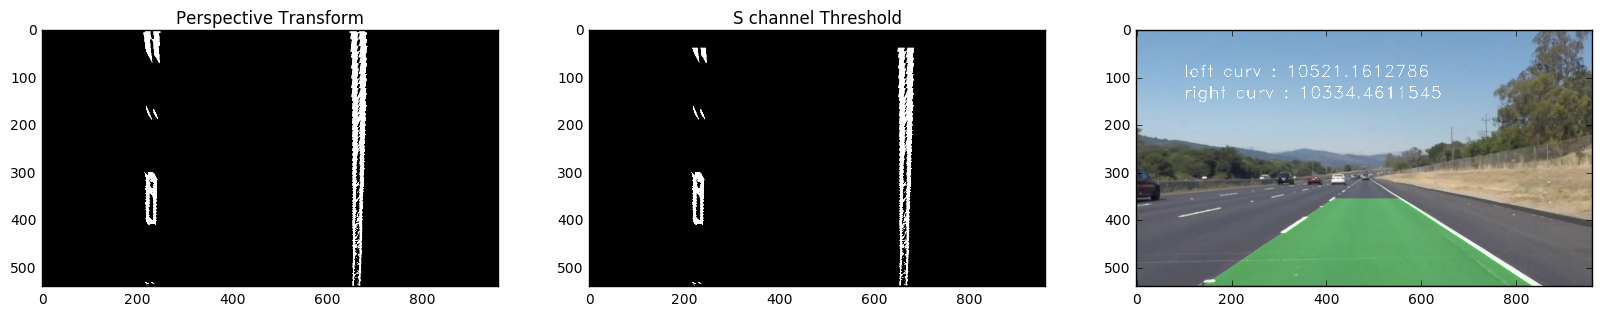

218 658


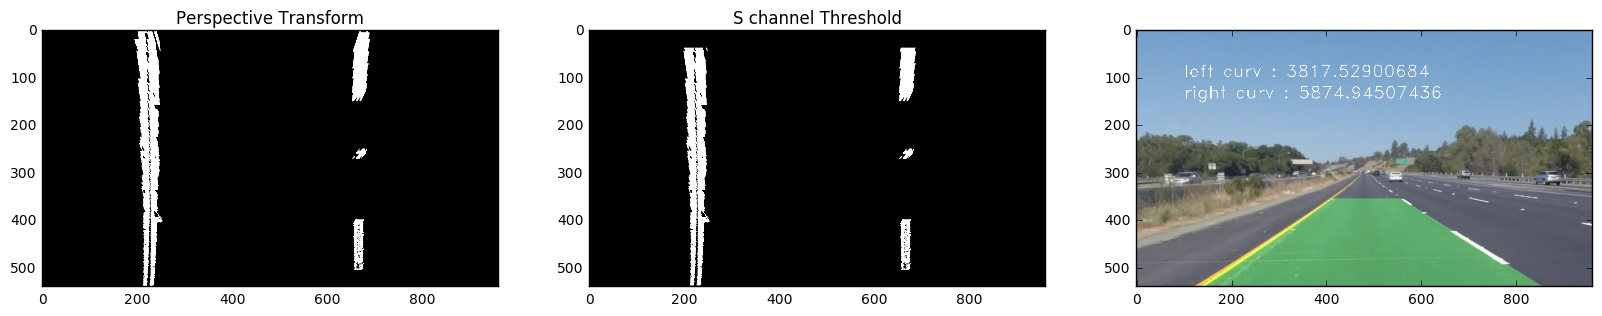

352 897


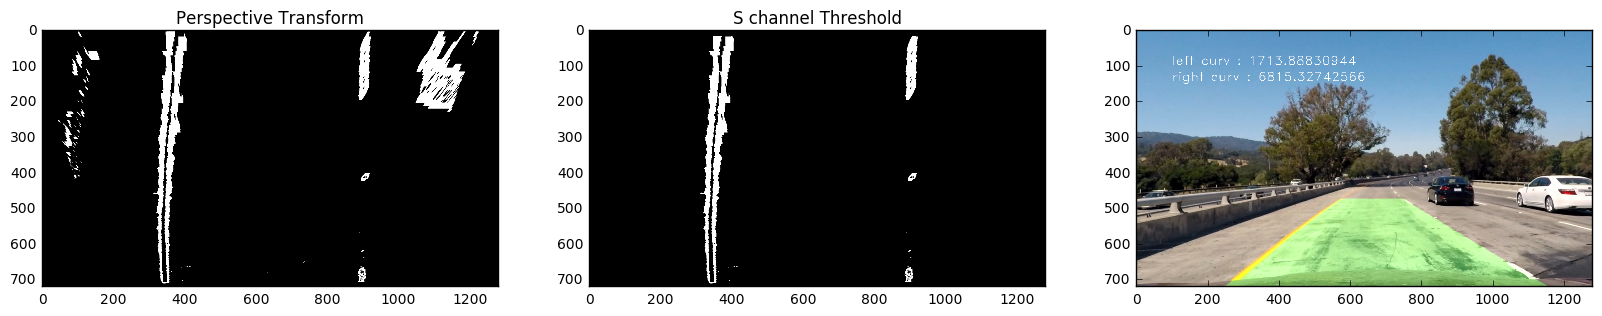

385 893


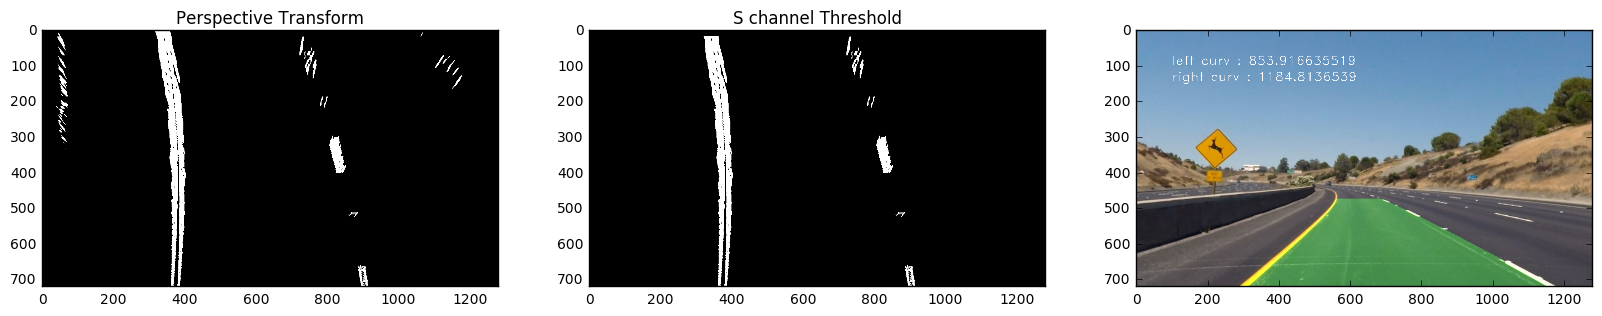

392 874


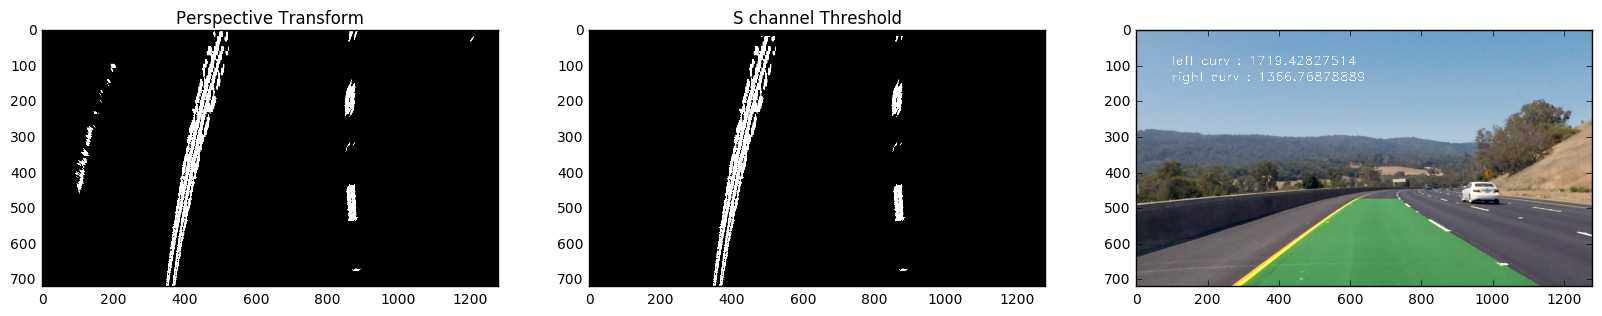

349 902


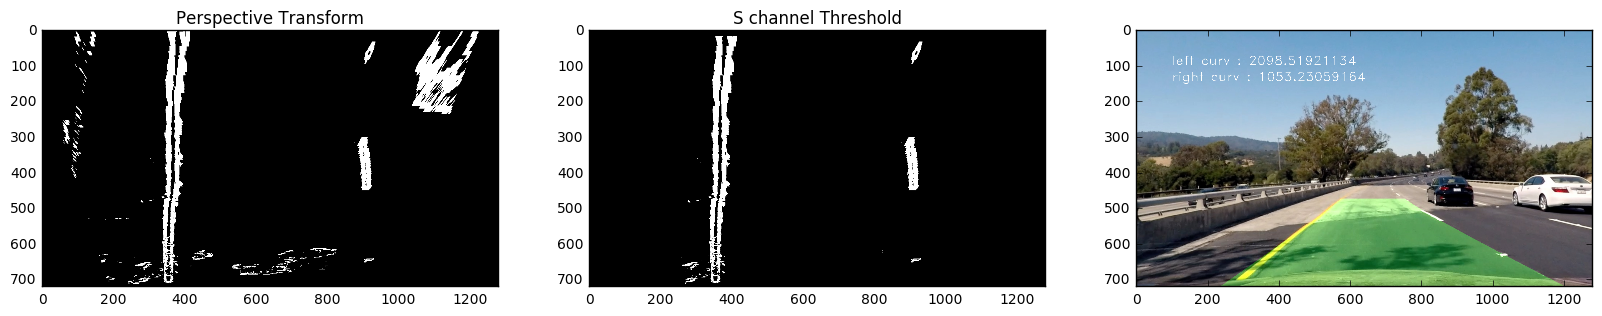

288 891


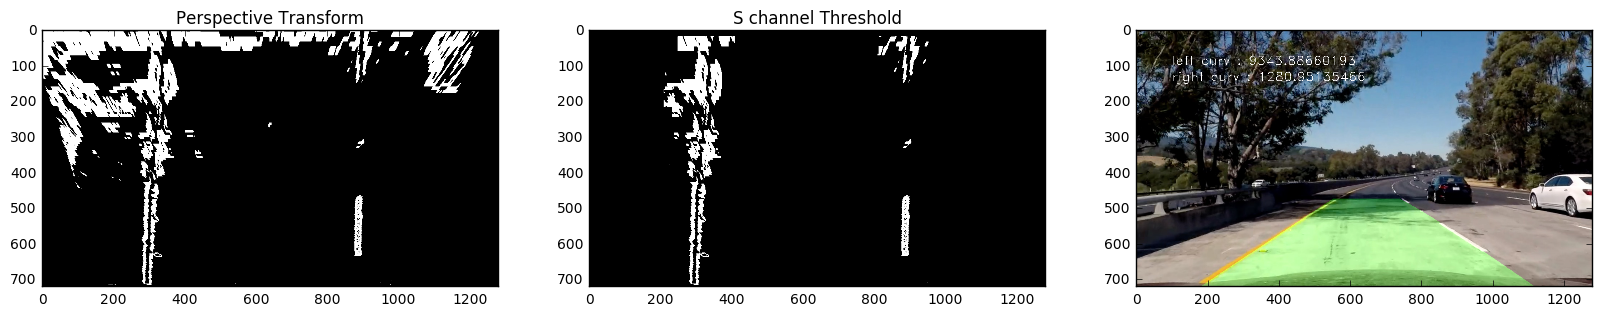

360 905


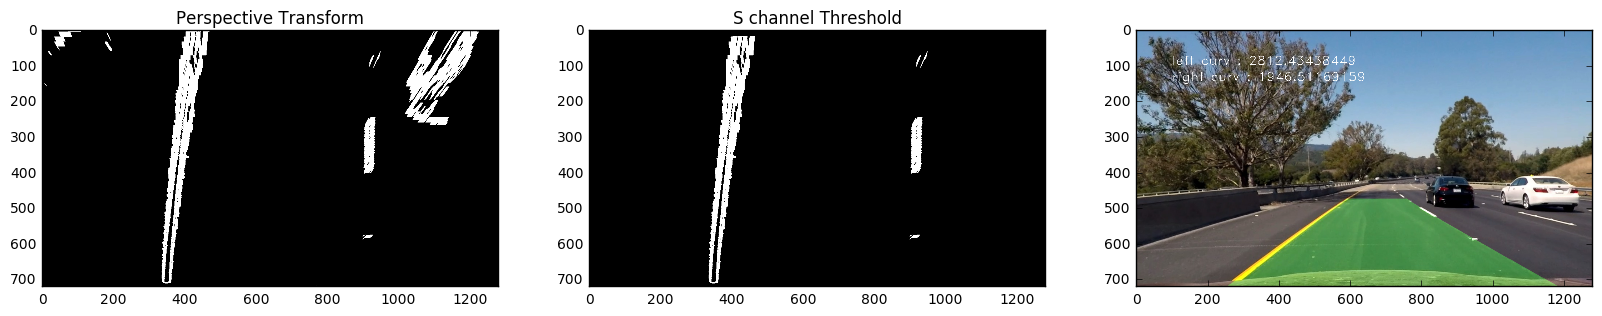

345 893


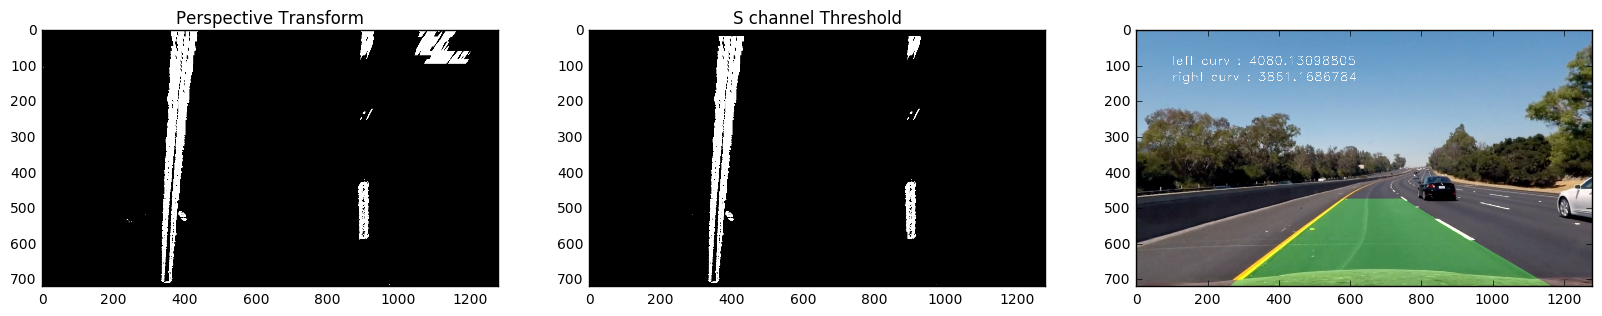

357 905


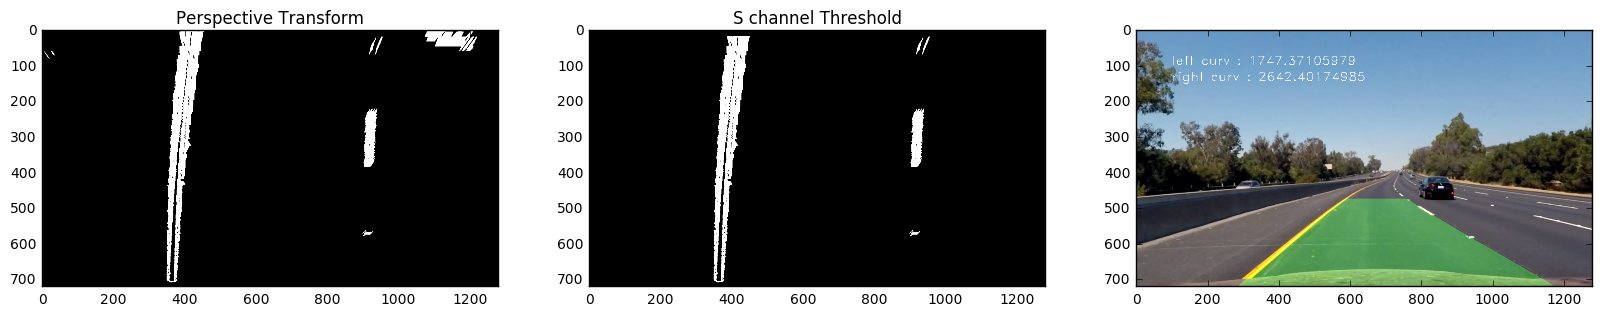

310 892


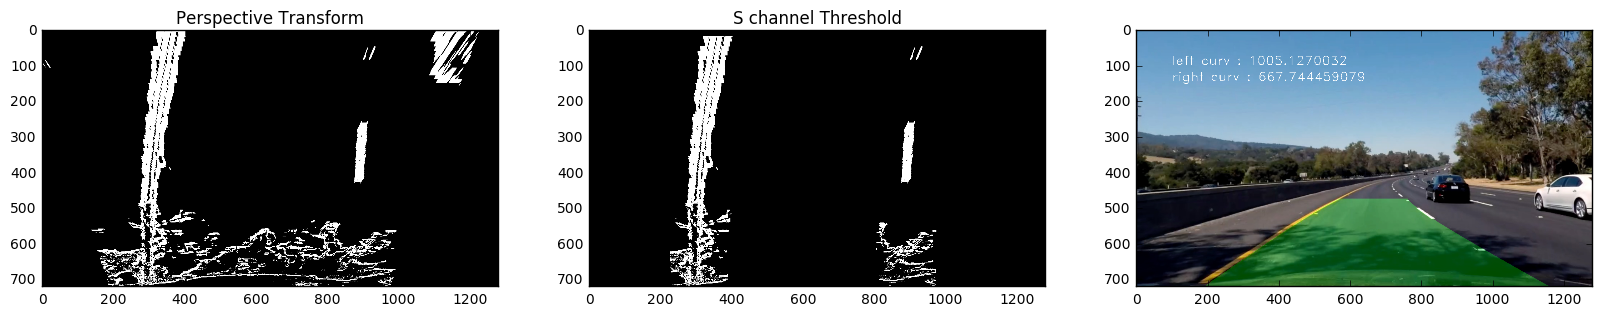

291 872


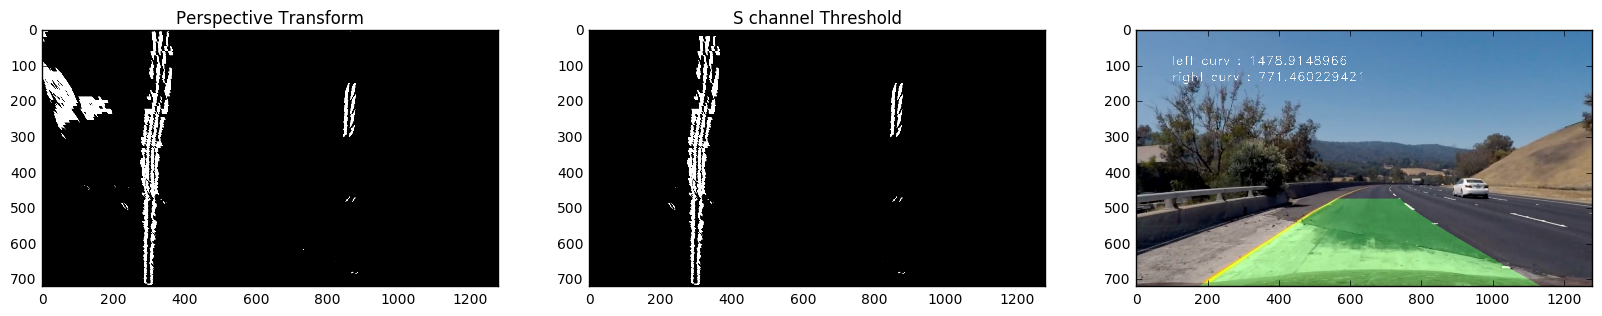

In [44]:
test_files = glob.glob('../test_images/*.jpg')

for file in test_files:
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
    imgRGB = cv2.imread(file)
    imgRGB = cv2.undistort(imgRGB,mtx,dist)
    imshape = imgRGB.shape
    p1 = (0,imshape[0])
    p2 = (int(0.5*imshape[1]),int(0.5*imshape[0]))
    p3 = (int(0.51*imshape[1]),int(0.5*imshape[0]))
    p4 = (imshape[1],imshape[0])
    vertices = np.array([[p1,p2, p3,p4]], dtype=np.int32) 
    imgHLS = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2HLS)
    imgGray = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2GRAY)
    masked_img = region_of_interest(imgGray,vertices)
    #RChannel = imgRGB[:,:,2]
    SChannel = imgHLS[:,:,2]
  
    sBinary = thresh_color(SChannel,SThresh)
    sBinary_gradient,sTheta = thresh_gradient(SChannel,kernel = 3 ,threshold = (25,255))
    binary_gradient,theta = thresh_gradient(imgGray,kernel = 3 ,threshold = GThresh,angle = 1.2 )
    merged_binary = np.zeros_like(binary_gradient)
    
   # sBinary_gradient [ sTheta > 1 ] = 0
#     sBinary [ sTheta > 1 ] = 0
    merged_binary [(binary_gradient ==1) | (sBinary_gradient == 1)] = 1
    #merged_binary &= masked_img[:,:,0]
    merged_binary  = np.bitwise_and(merged_binary,masked_img)
#     Sobely = cv2.Sobel(sBinary,cv2.CV_64F,0,1,3)
#     Sobely = np.abs(Sobely)
#     scale = 255.0/np.max(Sobely)
#     Sobely = (Sobely*scale).astype(np.uint8)
#     merged_binary[Sobely > 100] =0
    perTransform,M,Minv = perspective_transform(merged_binary)
    dict = find_lane_pixels(perTransform)
    rightX = dict['rightX']
    rightY = dict['rightY']
    leftY = dict['leftY']
    leftX = dict['leftX']
    leftX = [i for list in leftX for i in list]
    leftY = [i for list in leftY for i in list] 
    rightX = [i for list in rightX for i in list]
    rightY = [i for list in rightY for i in list]
    leftLane = Line(buffer_size = 5)
    rightLane = Line(buffer_size = 5)
    lane_pixels = np.zeros(imshape[:2])
    lane_pixels[leftY,leftX] = 255
    lane_pixels[rightY,rightX] = 255
    Lanes,left_curverad,right_curverad = fit_lanes(dict,imshape)
    Lanes = cv2.warpPerspective(Lanes,Minv,(imshape[1],imshape[0]))
    image = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2RGB)
    final_out = cv2.addWeighted(image, 1, Lanes, 0.3, 0)
    cv2.putText(final_out,"left curv : " + str(left_curverad),(100,100), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    cv2.putText(final_out,"right curv : " + str(right_curverad),(100,145), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    

    
    ax1.imshow(perTransform,cmap = 'gray')
    ax2.imshow(lane_pixels,cmap = 'gray')
    ax3.imshow(final_out)
    ax1.set_title('Perspective Transform')
    ax2.set_title('S channel Threshold')
    plt.show()

In [24]:
leftLane = Line(buffer_size = 10)
rightLane = Line(buffer_size = 10)
def process_image(img):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
    #imgRGB = cv2.imread(file)
    #imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgRGB=img
    imgRGB = cv2.undistort(imgRGB,mtx,dist)
    imshape = imgRGB.shape
    p1 = (0,imshape[0])
    p2 = (int(0.5*imshape[1]),int(0.5*imshape[0]))
    p3 = (int(0.51*imshape[1]),int(0.5*imshape[0]))
    p4 = (imshape[1],imshape[0])
    vertices = np.array([[p1,p2, p3,p4]], dtype=np.int32) 
    imgHLS = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2HLS)
    imgGray = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2GRAY)
    masked_img = region_of_interest(imgGray,vertices)
    #RChannel = imgRGB[:,:,2]
    SChannel = imgHLS[:,:,2]
     
    sBinary_gradient,sTheta = thresh_gradient(SChannel,kernel = 3 ,threshold = (25,255))
    binary_gradient,_ = thresh_gradient(imgGray,kernel = 3 ,threshold = GThresh)
    merged_binary = np.zeros_like(binary_gradient)
    merged_binary [(binary_gradient ==1) | (sBinary_gradient ==1)] = 1
    
    merged_binary  = np.bitwise_and(merged_binary,masked_img)
    perTransform,M,Minv = perspective_transform(merged_binary)
    dict = find_lane_pixels(perTransform)
    Lanes,left_curverad,right_curverad = fit_lanes(dict,imshape)
    Lanes = cv2.warpPerspective(Lanes,Minv,(imshape[1],imshape[0]))
    final_out = cv2.addWeighted(img, 1, Lanes, 0.3, 0)
    cv2.putText(final_out,"left curv : " + str(left_curverad),(100,100), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    cv2.putText(final_out,"right curv : " + str(right_curverad),(100,145), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    return final_out

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
out_video = 'out.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(out_video, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [11:58<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 13min 12s, sys: 1min 18s, total: 14min 31s
Wall time: 11min 59s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_video))